In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos
Exemple pour la région centre val de Loire.  
Récupération des codes_bss dans la liste des départements pour les fichiers dispos

In [3]:
region = "NAQ"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        WHERE code_dpt IN (16,17,19,23,24,33,40)
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [4]:
code_bss

['07372X0048_F10',
 '09765X0157_R10',
 '08081X0026_SE.20',
 '08022X0013_SP0',
 '09266X0004_LC101',
 '09788X0014_PCE101',
 '07543X0023_F11',
 '07791X0220_PZEM11',
 '09765X0158_R11',
 '09516X0030_P21',
 '07598X0005_A81',
 '07345X0020_F1',
 '08268X0020_F1',
 '08035X0360_F1',
 '08291X0001_F1',
 '08032X0001_F1',
 '07542X0001_F1',
 '07793X0001_F1',
 '07804X0001_F1',
 '08254X0001_F1',
 '07305X0001_F1',
 '08026X0001_F1',
 '08057X0001_F1',
 '07788X0001_F1',
 '07298X0001_F1',
 '09518X0021_F1',
 '07786X0051_F1',
 '08266X0061_F1',
 '08271X0002_F1',
 '07783X0002_F1',
 '07545X0002_F1',
 '08756X0032_F1',
 '07542X0042_F1',
 '08271X0152_F1',
 '08277X0152_F1',
 '08277X0162_F1',
 '08523X0092_F1',
 '09521X0013_F1',
 '08311X0023_F1',
 '08278X0023_F1',
 '08277X0153_F1',
 '07346X0083_F1',
 '08501X0004_F1',
 '08264X0004_F1',
 '09492X0014_F1',
 '09257X0054_F1',
 '08272X0005_F1',
 '07796X0025_F1',
 '08051X0035_F1',
 '08066X0045_F1',
 '08277X0155_F1',
 '08276X0085_F1',
 '08996X0006_F1',
 '08271X0106_F1',
 '08733

## Construction d'un dataframe

In [5]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [6]:
data

07372X0048_F10  09765X0157_R10  08081X0026_SE.20  08022X0013_SP0  \
date_mesure                                                                     
1942-01-01              NaN             NaN               NaN             NaN   
1942-08-18              NaN             NaN               NaN             NaN   
1951-12-01              NaN             NaN               NaN             NaN   
1956-05-04              NaN             NaN               NaN             NaN   
1959-03-10              NaN             NaN               NaN             NaN   
...                     ...             ...               ...             ...   
2022-05-26              NaN             NaN             -1.20             NaN   
2022-05-27              NaN             NaN             -1.19             NaN   
2022-05-28              NaN             NaN             -1.20             NaN   
2022-05-29              NaN             NaN             -1.20             NaN   
2022-05-30              NaN             NaN               NaN             NaN   

             09266X0004_LC101  09788X0014_PCE101  07543X0023_F11  \
date_mesure                                                        
1942-01-01                NaN                NaN             NaN   
1942-08-18                NaN                NaN             NaN   
1951-12-01                NaN                NaN             NaN   
1956-05-04                NaN                NaN             NaN   
1959-03-10                NaN                NaN             NaN   
...                       ...                ...             ...   
2022-05-26             -32.13                NaN           -2.96   
2022-05-27             -32.16                NaN           -2.97   
2022-05-28             -32.15                NaN           -2.97   
2022-05-29             -32.13                NaN           -2.99   
2022-05-30             -32.13                NaN             NaN   

             07791X0220_PZEM11  09765X0158_R11  09516X0030_P21  ...  \
date_mesure                                                     ...   
1942-01-01                 NaN             NaN             NaN  ...   
1942-08-18                 NaN             NaN             NaN  ...   
1951-12-01                 NaN             NaN             NaN  ...   
1956-05-04                 NaN             NaN             NaN  ...   
1959-03-10                 NaN             NaN             NaN  ...   
...                        ...             ...             ...  ...   
2022-05-26               -1.17             NaN             NaN  ...   
2022-05-27               -1.17             NaN             NaN  ...   
2022-05-28               -1.15             NaN             NaN  ...   
2022-05-29               -1.14             NaN             NaN  ...   
2022-05-30               -1.15             NaN             NaN  ...   

             07803X0004_HY  07072X0005_HY  09784X0029_CHICOY  08087X0022_PZ  \
date_mesure                                                                   
1942-01-01             NaN            NaN                NaN            NaN   
1942-08-18             NaN            NaN                NaN            NaN   
1951-12-01             NaN            NaN                NaN            NaN   
1956-05-04             NaN            NaN                NaN            NaN   
1959-03-10             NaN            NaN                NaN            NaN   
...                    ...            ...                ...            ...   
2022-05-26             NaN            NaN                NaN         -24.10   
2022-05-27             NaN            NaN                NaN         -24.08   
2022-05-28             NaN            NaN                NaN         -24.06   
2022-05-29             NaN            NaN                NaN         -24.06   
2022-05-30             NaN            NaN                NaN            NaN   

             07298X0042_PZ  08986X0052_PZ  09518X0025_PZ  06335X0006_PZ  \
date_mesure                                    

## Visualisation des valeurs manquantes

In [7]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

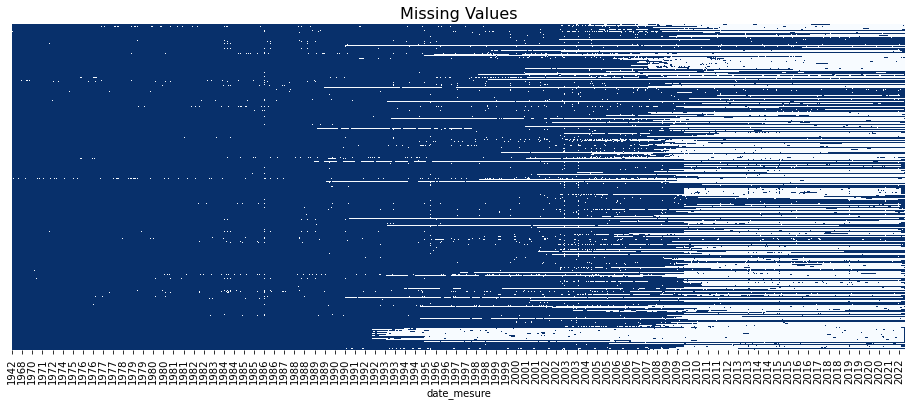

In [8]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [9]:
data_week = pd.DataFrame(data.resample('7D').mean())

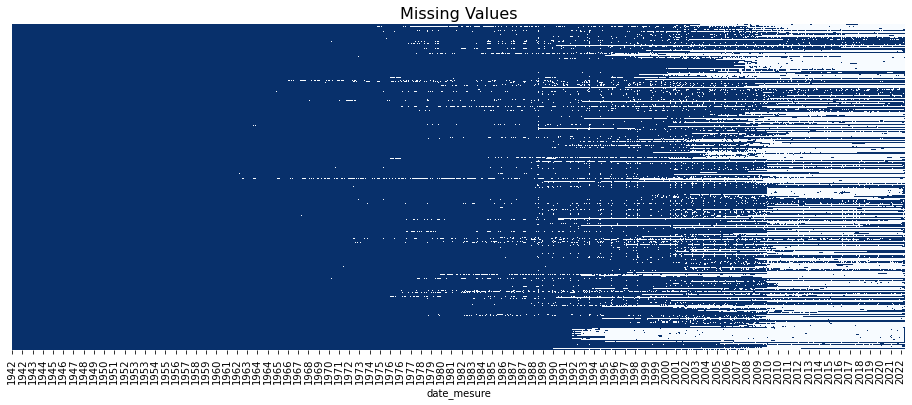

In [10]:
f_plot_nan(data_week)

In [11]:
data_week.shape

(4196, 678)

## Echelle de temps fixée après 2010 pour limiter les Nan

In [12]:
data_week_from_ = data_week.loc['01-01-2010':]

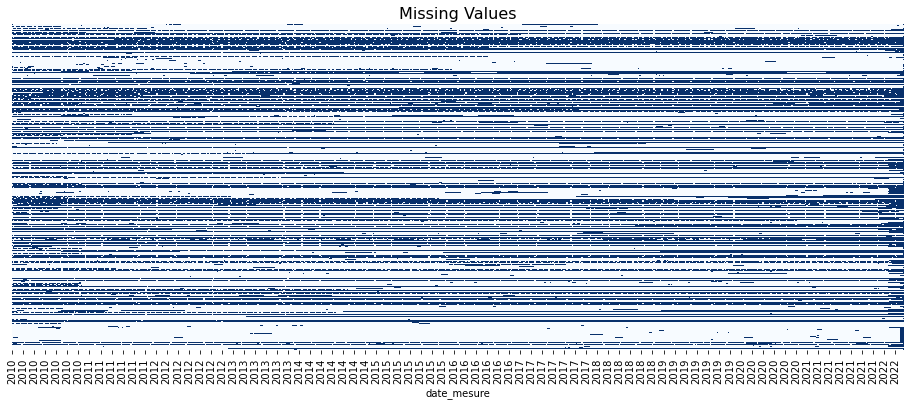

In [13]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [14]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 154334 valeurs nulles dans l'ensemble du dataframe.


In [15]:
data_wo_outliers = data_week_from_.copy()

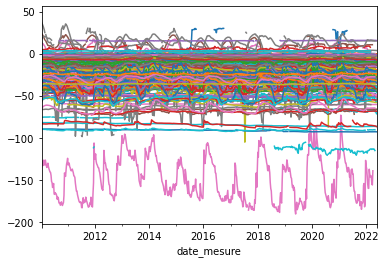

In [16]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

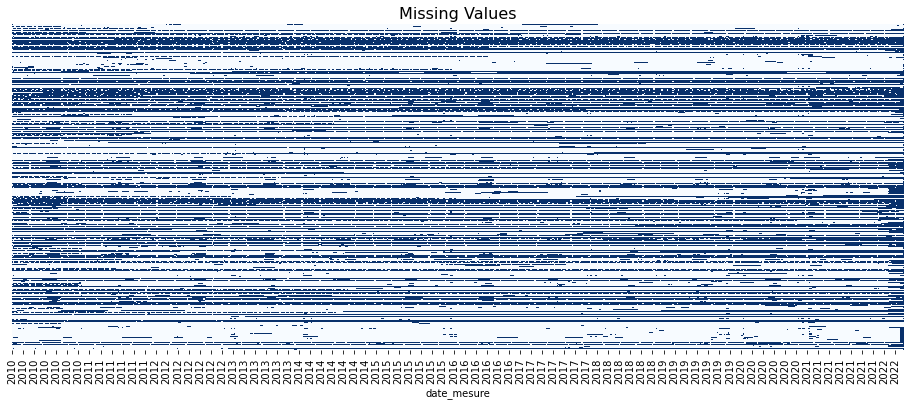

In [17]:
f_plot_nan(data_wo_outliers)

In [18]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 159851 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 5% de valeurs manquantes

In [19]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

In [20]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

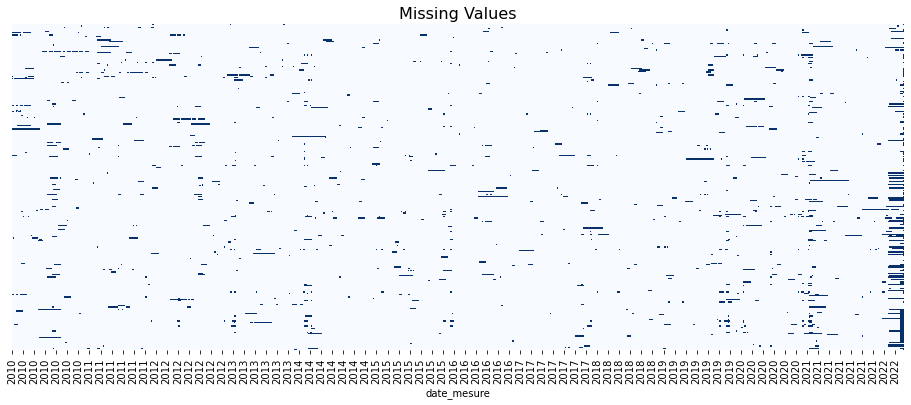

In [21]:
f_plot_nan(data_clean)

In [22]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 3240 valeurs nulles dans l'ensemble du dataframe.


In [23]:
data_clean.shape

(647, 260)

## Interpolation

In [24]:
data_interpol = data_clean.copy().interpolate('linear')

In [25]:
data_interpol.shape

(647, 260)

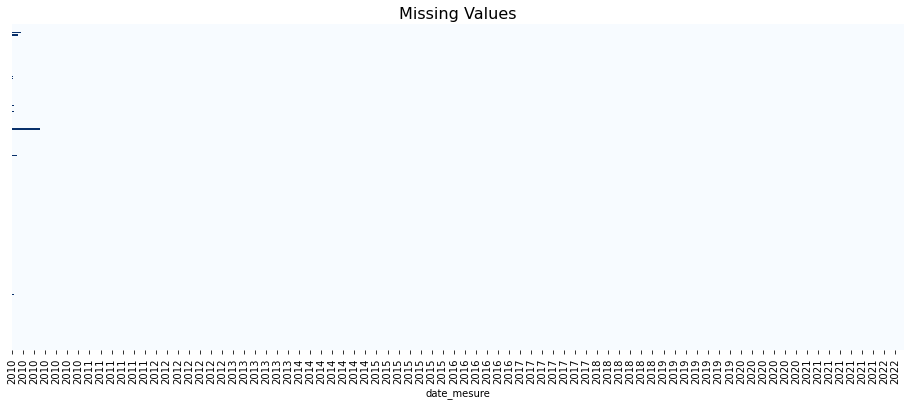

In [26]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [27]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [28]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-26 00:00:00', freq='7D')

In [29]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [30]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [31]:
data_interpol.shape

(626, 260)

In [33]:
data_interpol.shape[1]

260

## Affichage des chroniques après nettoyage

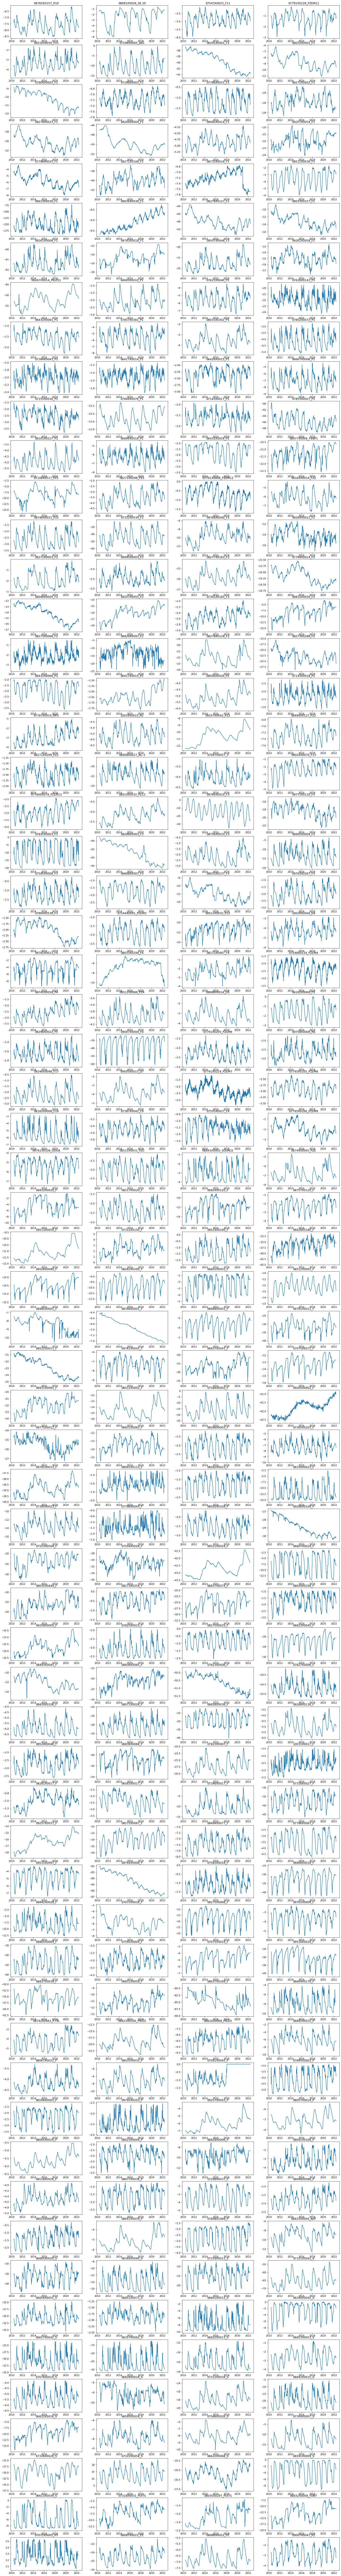

In [34]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [35]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [36]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [37]:
data_norm.head()

09765X0157_R10  08081X0026_SE.20  07543X0023_F11  \
date_mesure                                                     
2010-06-03         0.427391          0.697457       -0.409669   
2010-06-10         0.355307          0.833390       -0.469957   
2010-06-17         0.870575          0.831515       -0.136361   
2010-06-24         0.859896          0.830578       -0.393592   
2010-07-01         0.705048          0.829640       -0.646804   

             07791X0220_PZEM11  09516X0030_P21  07598X0005_A81  08291X0001_F1  \
date_mesure                                                                     
2010-06-03            0.371217       -0.310586        0.168743       1.479739   
2010-06-10            0.379077       -0.387679        0.211602       1.456934   
2010-06-17            0.426238       -0.267504        0.548121       1.445075   
2010-06-24            0.358640       -0.358202        0.405937       1.392168   
2010-07-01            0.145892       -0.637101        0.263754       1.341084   

             08032X0001_F1  07804X0001_F1  07298X0001_F1  ...  06622X0068_S  \
date_mesure                                               ...                 
2010-06-03        1.249173       1.377590       0.203326  ...      0.783763   
2010-06-10        1.321791       1.340918       0.257106  ...      0.817768   
2010-06-17        1.366168       1.339451       0.223494  ...      0.579738   
2010-06-24        1.362134       1.273441       0.270551  ...      0.490477   
2010-07-01        1.194037       1.095947       0.001653  ...      0.388464   

             06591X0009_S  06613X0039_S  07318X0031_PUITS  08035X0297_PUITS  \
date_mesure                                                                   
2010-06-03       0.520510     -0.111086         -0.963304         -0.760376   
2010-06-10       0.398258     -0.229062         -1.096511         -0.921407   
2010-06-17       0.253146     -0.318136         -0.915233         -1.013425   
2010-06-24       0.075732     -0.498179         -1.235680         -1.036429   
2010-07-01      -0.125537     -0.622788         -1.642546         -1.036429   

             06832X0008_FONT  07072X0005_HY  08087X0022_PZ  08986X0052_PZ  \
date_mesure                                                                 
2010-06-03         -0.402502      -0.654143       0.568773      -0.205788   
2010-06-10         -0.383674      -0.711908       1.296632      -0.236505   
2010-06-17         -0.351006      -0.307556       1.519975      -0.276674   
2010-06-24         -0.605266      -0.423085       1.468127      -0.323932   
2010-07-01         -1.179281      -0.769672       1.290649      -0.366464   

             09007X0047_PZ  
date_mesure                 
2010-06-03        0.114122  
2010-06-10        0.128029  
2010-06-17        0.203526  
2010-06-24       -0.438195  
2010-07-01       -0.918989  

[5 rows x 260 columns]

## Sauvegarde du dataframe en csv

In [38]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")